## Lab: Landsat Data Discovery and Access with STAC

In [25]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import planetary_computer
import pystac_client
import xarray as xr
from dask.distributed import Client, LocalCluster
from IPython.display import Image
from odc.stac import configure_rio, stac_load
from shapely.geometry import box

### Part 1: Understand what data is available and how STAC organizes it.

We start off my connecting to the Planetary Computer STAC catalog using `pystac_client`. We pass the `sign_inplace` modifier to automatically sign requests using the Planetary Computer's token, rather than needing to log in.

In [2]:
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)
catalog.title

'Microsoft Planetary Computer STAC API'

Next, we'll search for all the Landsat collections in the catalog.

In [3]:
all_collections = [i.id for i in catalog.get_collections()]
landsat_collections = [
    collection for collection in all_collections if "landsat" in collection
]
landsat_collections

['landsat-8-c2-l2', 'landsat-c2-l2', 'landsat-c2-l1']

In [4]:
landsat = catalog.get_collection("landsat-c2-l2")

Let's check out the metadata for the Landsat Collection 2 Level-2.

In [5]:
landsat

<CollectionClient id=landsat-c2-l2>

We can neatly look at all the item assets associated with the collection. We'll specifically want the red, green, blue, and NIR bands, as well as the qa_pixel band for cloud masking.

In [6]:
pd.DataFrame.from_dict(landsat.extra_fields["item_assets"], orient="index")[
    ["title", "description"]
]

title  \
qa             Surface Temperature Quality Assessment Band   
ang                                Angle Coefficients File   
red                                               Red Band   
blue                                             Blue Band   
drad                              Downwelled Radiance Band   
emis                                       Emissivity Band   
emsd                    Emissivity Standard Deviation Band   
lwir                              Surface Temperature Band   
trad                                 Thermal Radiance Band   
urad                                Upwelled Radiance Band   
atran                       Atmospheric Transmittance Band   
cdist                                  Cloud Distance Band   
green                                           Green Band   
nir08                               Near Infrared Band 0.8   
lwir11                            Surface Temperature Band   
swir16                        Short-wave Infrared Band 1.6   
swir22                        Short-wave Infrared Band 2.2   
coastal                               Coastal/Aerosol Band   
mtl.txt                        Product Metadata File (txt)   
mtl.xml                        Product Metadata File (xml)   
cloud_qa                     Cloud Quality Assessment Band   
mtl.json                      Product Metadata File (json)   
qa_pixel                     Pixel Quality Assessment Band   
qa_radsat                                              NaN   
qa_aerosol                 Aerosol Quality Assessment Band   
atmos_opacity                     Atmospheric Opacity Band   

                                                     description  
qa             Collection 2 Level-2 Quality Assessment Band (...  
ang                 Collection 2 Level-1 Angle Coefficients File  
red                                                          NaN  
blue                                                         NaN  
drad           Collection 2 Level-2 Downwelled Radiance Band ...  
emis           Collection 2 Level-2 Emissivity Band (ST_EMIS)...  
emsd           Collection 2 Level-2 Emissivity Standard Devia...  
lwir           Collection 2 Level-2 Thermal Infrared Band (ST...  
trad           Collection 2 Level-2 Thermal Radiance Band (ST...  
urad           Collection 2 Level-2 Upwelled Radiance Band (S...  
atran          Collection 2 Level-2 Atmospheric Transmittance...  
cdist          Collection 2 Level-2 Cloud Distance Band (ST_C...  
green                                                        NaN  
nir08                                                        NaN  
lwir11         Collection 2 Level-2 Thermal Infrared Band (ST...  
swir16                                                       NaN  
swir22         Collection 2 Level-2 Short-wave Infrared Band ...  
coastal        Collection 2 Level-2 Coastal/Aerosol Band (SR_...  
mtl.txt         Collection 2 Level-2 Product Metadata File (txt)  
mtl.xml         Collection 2 Level-2 Product Metadata File (xml)  
cloud_qa       Collection 2 Level-2 Cloud Quality Assessment ...  
mtl.json       Collection 2 Level-2 Product Metadata File (json)  
qa_pixel       Collection 2 Level-1 Pixel Quality Assessment ...  
qa_radsat                                                    NaN  
qa_aerosol     Collection 2 Level-2 Aerosol Quality Assessmen...  
atmos_opacity  Collection 2 Level-2 Atmospheric Opacity Band ...

## Part 2: Query for imagery over your study area and verify the results make sense.

We're going to pull in all the imagery for Singapore for 2025. We've set the bounding box to be pretty restrictive--we deliberately chose Singapore as a class exercise because 1) it has high cloud cover, and 2) it's small enough that we don't need multiple Landsat tiles to cover the AOI. Expanding the AOI is doable but would require us to load more data--totally feasible, but not helpful for the class exercise, when we need our code to run quickly.

In [7]:
bbox = [103.70, 1.25, 103.90, 1.45]  # singapore bounding box (west, south, east, north)
datetime = "2025-01-01/2025-12-31"  # Full year of 2025
collection = "landsat-c2-l2"

Next, we'll set up our Dask cluster and configure rasterio for efficient cloud COG access. This is crucial to making sure we can efficiently load the data. You'll need to configure your cluster based on your system's capabilities. I'm working on a machine with 16 cores and 64GB of RAM, so I'm using 8 workers and 2 threads per worker.

In [8]:
cluster = LocalCluster(
    processes=True,
    n_workers=8,
    threads_per_worker=2,
    memory_limit="6GB",
)
client = Client(cluster)
configure_rio(cloud_defaults=True, client=client)

/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/distributed/node.py:188: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33253 instead
  warnings.warn(


We're searching for scenes with less than 50% cloud cover. Singapore is so cloudy that we need to set a threshold of less than 50% to get more than a handful of scenes--otherwise, our median composite will have a lot of NaN values. Later, we'll use the QA band to mask out clouds and cloud shadows, so this will be okay for viz purposes.

In [9]:
search = catalog.search(
    bbox=bbox,
    datetime=datetime,
    collections=collection,
    query={"eo:cloud_cover": {"lt": 50}},
)

items = search.item_collection()

We can count and list all the items returned by our query:

In [10]:
print(f"Returned {len(items)} Items:")
item_id = {(i, item.id): i for i, item in enumerate(items)}
item_id

Returned 23 Items:


{(0, 'LC08_L2SP_125059_20251205_02_T1'): 0,
 (1, 'LC09_L2SP_125059_20251026_02_T1'): 1,
 (2, 'LC08_L2SP_125059_20251018_02_T1'): 2,
 (3, 'LC08_L2SP_125059_20251002_02_T1'): 3,
 (4, 'LC09_L2SP_125059_20250924_02_T1'): 4,
 (5, 'LC08_L2SP_125059_20250916_02_T2'): 5,
 (6, 'LC08_L2SP_125059_20250831_02_T1'): 6,
 (7, 'LC08_L2SP_125059_20250815_02_T1'): 7,
 (8, 'LC09_L2SP_125059_20250807_02_T1'): 8,
 (9, 'LC08_L2SP_125059_20250730_02_T1'): 9,
 (10, 'LC09_L2SP_125059_20250706_02_T1'): 10,
 (11, 'LC09_L2SP_125059_20250604_02_T1'): 11,
 (12, 'LC08_L2SP_125059_20250527_02_T1'): 12,
 (13, 'LC08_L2SP_125059_20250511_02_T1'): 13,
 (14, 'LC09_L2SP_125059_20250503_02_T1'): 14,
 (15, 'LC08_L2SP_125059_20250425_02_T1'): 15,
 (16, 'LC08_L2SP_125059_20250409_02_T1'): 16,
 (17, 'LC09_L2SP_125059_20250401_02_T1'): 17,
 (18, 'LC08_L2SP_125059_20250308_02_T1'): 18,
 (19, 'LC08_L2SP_125059_20250220_02_T1'): 19,
 (20, 'LC09_L2SP_125059_20250212_02_T1'): 20,
 (21, 'LC09_L2SP_125059_20250127_02_T2'): 21,
 (22, 'L

In [11]:
selected_item = items[0]
selected_item

<Item id=LC08_L2SP_125059_20251205_02_T1>

In [12]:
selected_item.assets

{'qa': <Asset href=https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2025/125/059/LC08_L2SP_125059_20251205_20251209_02_T1/LC08_L2SP_125059_20251205_20251209_02_T1_ST_QA.TIF?st=2026-01-14T16%3A57%3A39Z&se=2026-01-15T17%3A42%3A39Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2026-01-15T11%3A34%3A57Z&ske=2026-01-22T11%3A34%3A57Z&sks=b&skv=2025-07-05&sig=AF3e%2B/snJSfq1brOUDG81bn7CYVamYL8wsoT5ASVcjE%3D>,
 'ang': <Asset href=https://landsateuwest.blob.core.windows.net/landsat-c2/level-2/standard/oli-tirs/2025/125/059/LC08_L2SP_125059_20251205_20251209_02_T1/LC08_L2SP_125059_20251205_20251209_02_T1_ANG.txt?st=2026-01-14T16%3A57%3A39Z&se=2026-01-15T17%3A42%3A39Z&sp=rl&sv=2025-07-05&sr=c&skoid=9c8ff44a-6a2c-4dfb-b298-1c9212f64d9a&sktid=72f988bf-86f1-41af-91ab-2d7cd011db47&skt=2026-01-15T11%3A34%3A57Z&ske=2026-01-22T11%3A34%3A57Z&sks=b&skv=2025-07-05&sig=AF3e%2B/snJSfq1brOUDG81bn7CYVamYL8wsoT5A

We'll display a rendered preview of the scene. Having access to a rendered preview is a great way to verify that the scene is what you expect, without having to load huge volumes of data.

In [13]:
Image(url=selected_item.assets["rendered_preview"].href)

We can also plot the scene footprints on a map. This is a great way to verify that the scenes cover the area you expect.

In [14]:
df = gpd.GeoDataFrame.from_features(items.to_dict(), crs="epsg:4326")

bbox_geom = box(*bbox)
bbox_gdf = gpd.GeoDataFrame([{"geometry": bbox_geom}], crs="epsg:4326")

# Create map with footprints
m = df[["geometry", "datetime", "eo:cloud_cover"]].explore(
    column="eo:cloud_cover", style_kwds={"fillOpacity": 0.1}
)

# Add bbox polygon on top
bbox_gdf.explore(
    m=m, style_kwds={"color": "red", "weight": 4, "fillOpacity": 0}, name="Bounding Box"
)

m

We can also plot cloud cover over time.

<Axes: title={'center': 'eo:cloud-cover'}, xlabel='datetime'>

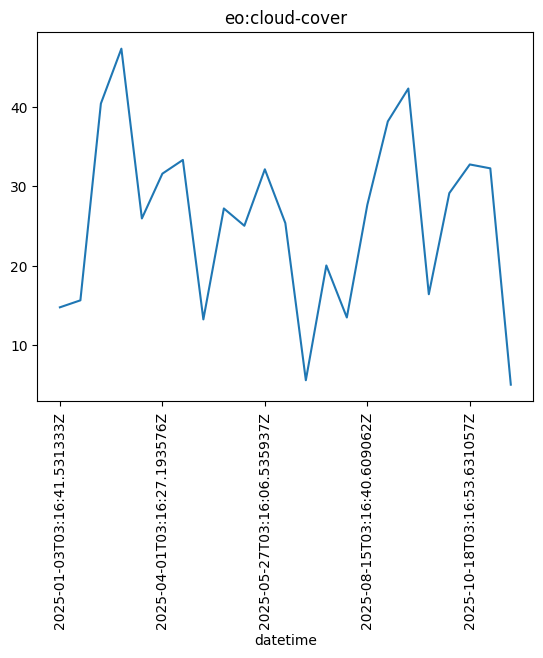

In [15]:
ts = df.set_index("datetime").sort_index()["eo:cloud_cover"]
ts.plot(title="eo:cloud-cover", rot=90)

### Part 3: Combine multiple scenes into a single cloud-free image.

Now, to load data, we're going to leverage the `stac_load` function from `odc`, which will also take advantage of Dask cluster we have running. It will allow us to efficiently load the data in parallel (rather than sequentially), dramatically speeding up the loading process.

In [16]:
# Load data including qa_pixel
data = stac_load(
    items,
    bands=["nir08", "red", "green", "blue", "qa_pixel"],
    crs="EPSG:3857",
    resolution=30,
    chunks={"time": -1, "x": 128, "y": 128},
    bbox=bbox,
)

The data are an xarray dataset with the spectral bands and the qa_pixel band. We can look at it in more depth:

In [17]:
data

<xarray.Dataset> Size: 127MB
Dimensions:      (y: 744, x: 743, time: 23)
Coordinates:
  * y            (y) float64 6kB 1.614e+05 1.614e+05 ... 1.392e+05 1.392e+05
  * x            (x) float64 6kB 1.154e+07 1.154e+07 ... 1.157e+07 1.157e+07
  * time         (time) datetime64[ns] 184B 2025-01-03T03:16:41.531333 ... 20...
    spatial_ref  int32 4B 3857
Data variables:
    nir08        (time, y, x) uint16 25MB dask.array<chunksize=(23, 128, 128), meta=np.ndarray>
    red          (time, y, x) uint16 25MB dask.array<chunksize=(23, 128, 128), meta=np.ndarray>
    green        (time, y, x) uint16 25MB dask.array<chunksize=(23, 128, 128), meta=np.ndarray>
    blue         (time, y, x) uint16 25MB dask.array<chunksize=(23, 128, 128), meta=np.ndarray>
    qa_pixel     (time, y, x) uint16 25MB dask.array<chunksize=(23, 128, 128), meta=np.ndarray>

In [18]:
total_bytes = sum(data[var].nbytes for var in data.data_vars)
print(f"Total size: {total_bytes / 1e9:.2f} GB ({total_bytes / 1e6:.2f} MB)")

Total size: 0.13 GB (127.14 MB)


In [19]:
print(f"CRS: {data.spatial_ref.spatial_ref}")
print(f"Spatial ref attrs: {data.spatial_ref.attrs}")

CRS: <xarray.DataArray 'spatial_ref' ()> Size: 4B
array(3857, dtype=int32)
Coordinates:
    spatial_ref  int32 4B 3857
Attributes:
    spatial_ref:   PROJCRS["WGS 84 / Pseudo-Mercator",BASEGEOGCRS["WGS 84",EN...
    crs_wkt:       PROJCRS["WGS 84 / Pseudo-Mercator",BASEGEOGCRS["WGS 84",EN...
    GeoTransform:  11543820 30 0 161460 0 -30
Spatial ref attrs: {'spatial_ref': 'PROJCRS["WGS 84 / Pseudo-Mercator",BASEGEOGCRS["WGS 84",ENSEMBLE["World Geodetic System 1984 ensemble",MEMBER["World Geodetic System 1984 (Transit)"],MEMBER["World Geodetic System 1984 (G730)"],MEMBER["World Geodetic System 1984 (G873)"],MEMBER["World Geodetic System 1984 (G1150)"],MEMBER["World Geodetic System 1984 (G1674)"],MEMBER["World Geodetic System 1984 (G1762)"],MEMBER["World Geodetic System 1984 (G2139)"],MEMBER["World Geodetic System 1984 (G2296)"],ELLIPSOID["WGS 84",6378137,298.257223563,LENGTHUNIT["metre",1]],ENSEMBLEACCURACY[2.0]],PRIMEM["Greenwich",0,ANGLEUNIT["degree",0.0174532925199433]],ID["EPSG",4326

We'll use the `qa_pixel` band to mask out cloudy pixels, setting them to NaN. We'll then create a median composite across all scenes. Since the median ignores NaN values, only clear pixels contribute to the final image. All of this is defined lazily; calling `.compute()` triggers the actual download and computation.

In [20]:
# Create cloud mask from qa_pixel
# Bit 3 = cloud, Bit 4 = cloud shadow
# Mask is True where pixels are CLEAR
cloud_mask = (data["qa_pixel"] & 0b11000) == 0

# Apply mask to spectral bands (clouds become NaN)
data_masked = data[["nir08", "red", "green", "blue"]].where(cloud_mask)

# Median now ignores NaN (cloudy) pixels
median = data_masked.median(dim="time")
result = median.compute()

/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(
/home/nissim/Documents/dev/musa-650-spring-2026/.venv/lib/python3.11

### Part 4: Visualize and export your results.

Now that we've calculated the median composite, we can visualize the results. We'll plot each band as a grayscale image, and then stack the RGB bands and normalize them to create a true-color composite.

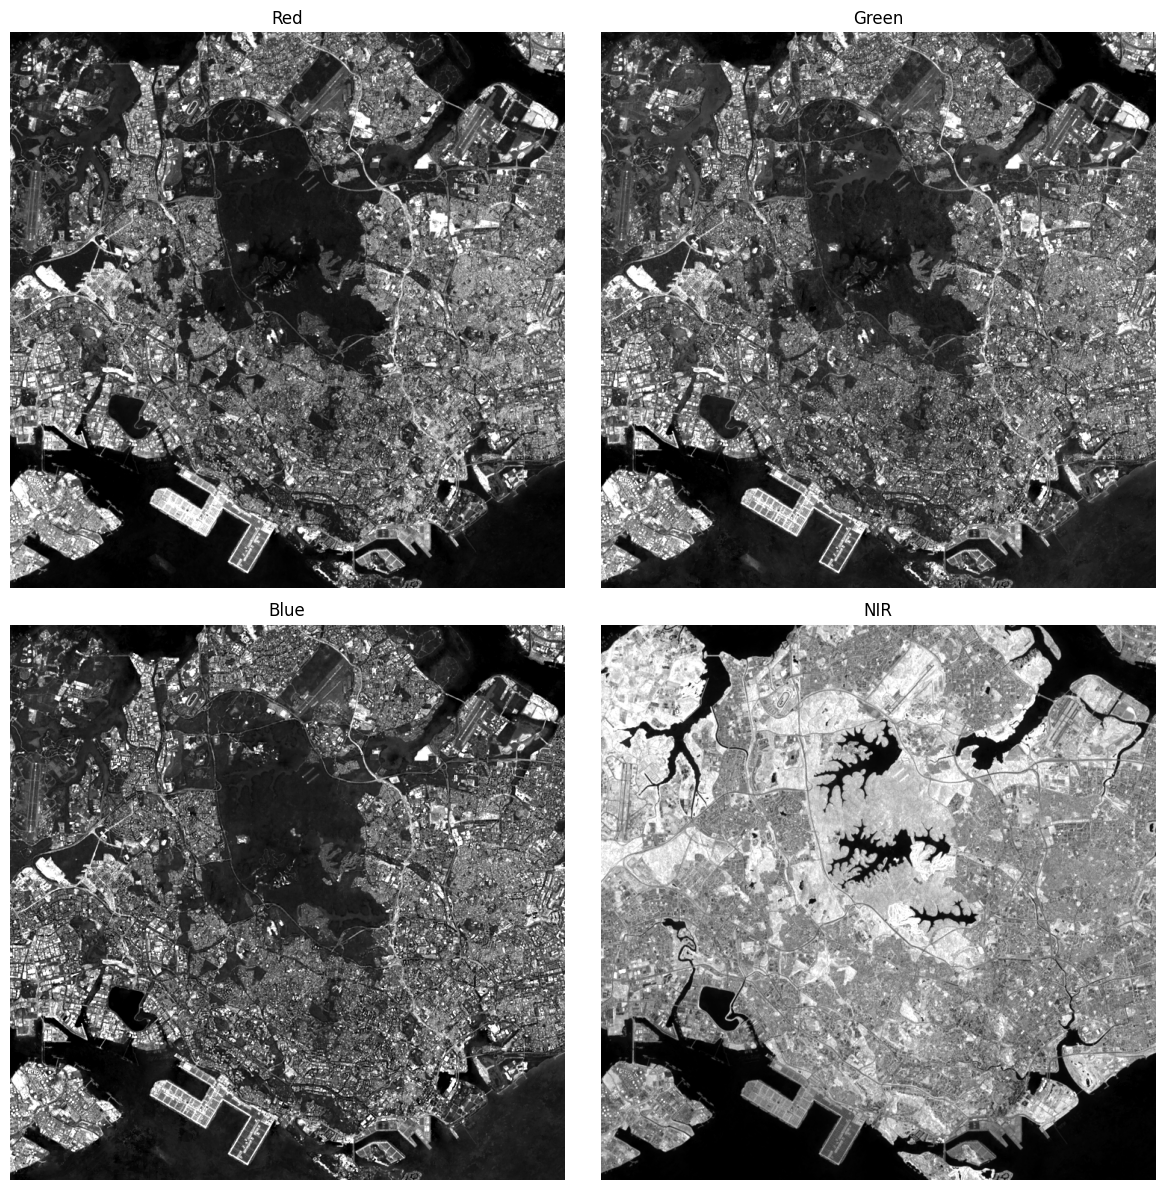

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

bands = ["red", "green", "blue", "nir08"]
band_names = ["Red", "Green", "Blue", "NIR"]

for ax, band, name in zip(axes.flat, bands, band_names):
    data = result[band].values

    # Normalize each band
    p2, p98 = np.nanpercentile(data, (2, 98))
    normalized = np.clip((data - p2) / (p98 - p2), 0, 1)

    ax.imshow(normalized, cmap="gray")
    ax.set_title(name)
    ax.axis("off")

plt.tight_layout()
plt.show()

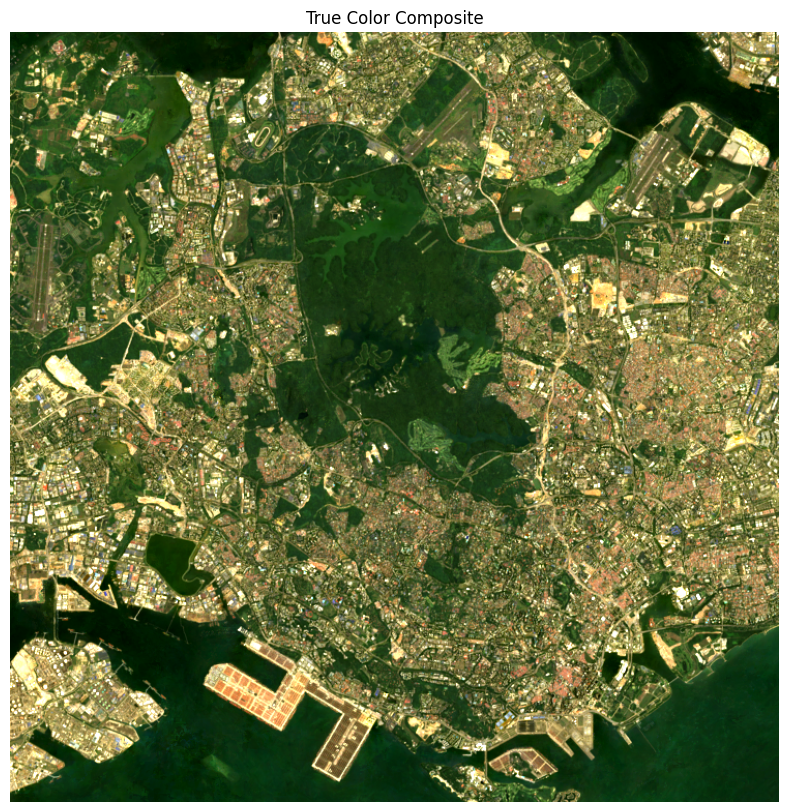

In [22]:
# Stack bands as RGB - access as dataset variables
rgb = np.stack(
    [result["red"].values, result["green"].values, result["blue"].values], axis=-1
)

# Normalize to 0-1 range
p2, p98 = np.nanpercentile(rgb, (2, 98))
rgb_normalized = np.clip((rgb - p2) / (p98 - p2), 0, 1)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(rgb_normalized)
ax.set_title("True Color Composite")
ax.axis("off")
plt.show()

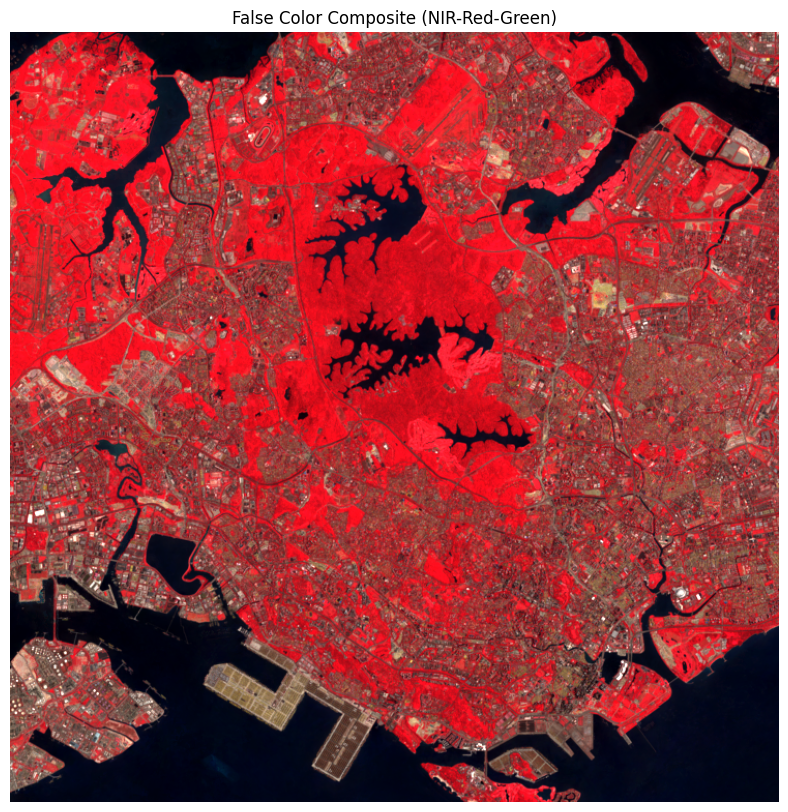

In [23]:
# Stack bands as NIR-Red-Green (false color)
false_color = np.stack(
    [result["nir08"].values, result["red"].values, result["green"].values], axis=-1
)

# Normalize to 0-1 range (adjust percentiles to taste)
p2, p98 = np.nanpercentile(false_color, (2, 98))
fc_normalized = np.clip((false_color - p2) / (p98 - p2), 0, 1)

# Plot
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(fc_normalized)
ax.set_title("False Color Composite (NIR-Red-Green)")
ax.axis("off")
plt.show()

Finally, we'll concatenate the RGB bands and write the result to a Cloud-Optimized GeoTIFF (COG). This is a great way to export the data for use in other GIS software.

In [26]:
result_rgb = xr.concat([result["red"], result["green"], result["blue"]], dim="band")
result_rgb = result_rgb.assign_coords(band=[1, 2, 3])
result_rgb.rio.write_crs("epsg:3857", inplace=True)
result_rgb.rio.to_raster("cloud_free_composite.tif", driver="COG")